In [2]:
import pandas as pd
import shap
import numpy as np
from xgboost import XGBClassifier, plot_tree, plot_importance
import random
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

random.seed(254)

/Users/laurenflemmer/Library/Python/3.8/lib/python/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/laurenflemmer/Library/Python/3.8/lib/python/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_min

#### Read in data

In [3]:
train_data = pd.read_csv("/Users/laurenflemmer/Desktop/poker_proj/data/poker-hand-training-true.data", header=None)
test_data = pd.read_csv("/Users/laurenflemmer/Desktop/poker_proj/data/poker-hand-testing.data", header=None)
test_data = test_data.sample(n=200000)
train_data.head()

train_data_transformed = pd.read_csv("/Users/laurenflemmer/Desktop/poker_proj/data/poker-hand-training-transformed.csv")
test_data_transformed = pd.read_csv("/Users/laurenflemmer/Desktop/poker_proj/data/poker-hand-test-transformed.csv")

train_oversampled_data = pd.read_csv("/Users/laurenflemmer/Desktop/poker_proj/data/oversampled_train.csv")
train_oversampled_data = train_oversampled_data.drop(['Unnamed: 0'], axis =1)

cards_train = train_data.drop(train_data.columns[10], axis =1)
hand_train = train_data[train_data.columns[10]]

cards_train_transformed = train_data_transformed.drop(['hand'], axis =1)
hand_train_transformed = train_data_transformed['hand']

cards_train_over = train_oversampled_data.drop(['hand'], axis =1)
hand_train_over = train_oversampled_data['hand']

cards_test = test_data.drop(train_data.columns[10], axis =1)
hand_test = test_data[train_data.columns[10]]

cards_test_transformed = test_data_transformed.drop(['hand'], axis =1)
hand_test_transformed = test_data_transformed['hand']

#### Training initial untuned model on untransformed data

In [12]:
# Define hyperparameters
weights = compute_sample_weight(class_weight='balanced', y=hand_train_transformed)

model = XGBClassifier(num_class = 10, eval_metric='merror') 

model.fit(cards_train_transformed, hand_train_transformed, sample_weight=weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=10, num_parallel_tree=None, objective='multi:softprob', ...)

In [6]:
print(cards_train_transformed.columns)

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       'clubs', 'diamonds', 'hearts', 'spades'],
      dtype='object')


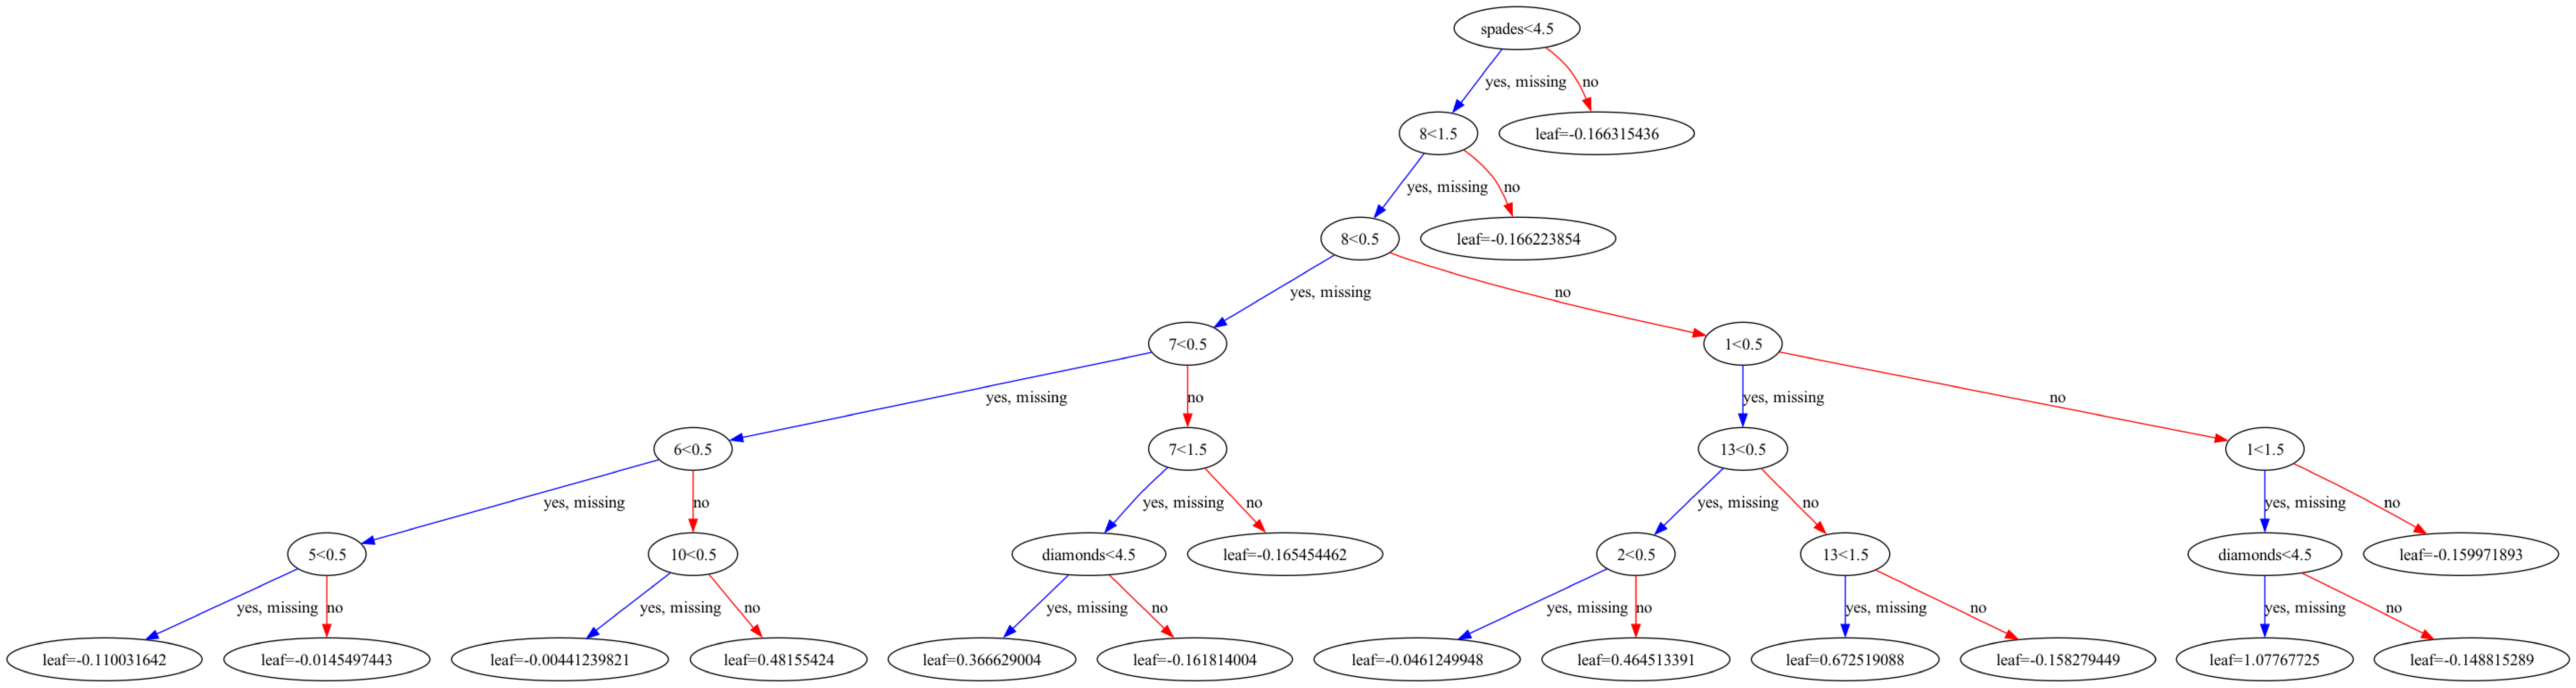

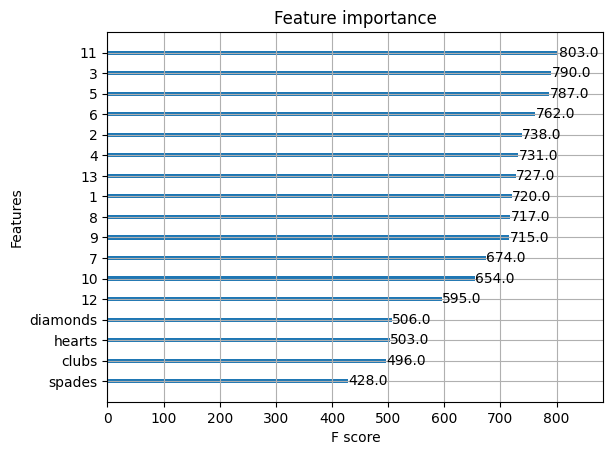

In [14]:
# plot tree
plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()


plot_importance(model)
plt.show()

#### Testing initial model on untransformed data

In [30]:
# test model
predicted_hand = model.predict(cards_test) 
predicted_hand = [round(value) for value in predicted_hand]

# accuracy and confusion matrix
accuracy = accuracy_score(hand_test, predicted_hand) 
print("Accuracy of initial model: %.2f%%" % (accuracy * 100.0))

matrix = confusion_matrix(hand_test, predicted_hand)
matrix.diagonal()/matrix.sum(axis=1)


Accuracy of initial model: 63.47%


array([0.79239149, 0.51361187, 0.31642134, 0.23185391, 0.1827957 ,
       0.21921182, 0.0174216 , 0.        , 0.        , 1.        ])

#### Training initial untuned model on transformed data

In [32]:
# Define hyperparameters
weights_transformed = compute_sample_weight(class_weight='balanced', y=hand_train_transformed)

# train model
model.fit(cards_train_transformed, hand_train_transformed, sample_weight=weights_transformed)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=10, num_parallel_tree=None, objective='multi:softprob', ...)

#### Testing initial model on transformed data

In [33]:
# test model
predicted_hand_transformed = model.predict(cards_test_transformed) 
predicted_hand_transformed = [round(value) for value in predicted_hand_transformed]

# accuracy and confusion matrix
accuracy_transformed = accuracy_score(hand_test_transformed, predicted_hand_transformed) 
print("Accuracy of initial model (transformed data): %.2f%%" % (accuracy_transformed * 100.0))

matrix_transformed = confusion_matrix(hand_test_transformed, predicted_hand_transformed)
matrix_transformed.diagonal()/matrix_transformed.sum(axis=1)

Accuracy of initial model (transformed data): 99.76%


array([0.99834864, 0.99995256, 1.        , 0.99904398, 0.99022346,
       0.90432802, 0.26027397, 0.36      , 0.        , 1.        ])

#### Training model on oversampled data

In [41]:
weights_oversampled = compute_sample_weight(class_weight='balanced', y=hand_train_over)

# train model
model_oversampled = XGBClassifier(num_class = 10) 

model_oversampled.fit(cards_train_over, hand_train_over, sample_weight=weights_oversampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=10,
              num_parallel_tree=None, objective='multi:softprob', ...)

#### Testing model

In [42]:
# test model
predicted_hand_oversampledModel = model_oversampled.predict(cards_test) 
predicted_hand_oversampledModel = [round(value) for value in predicted_hand_oversampledModel]

# accuracy and confusion matrix
accuracy_oversampled = accuracy_score(hand_test, predicted_hand_oversampledModel) 
print("Accuracy of model trained on oversampled data: %.2f%%" % (accuracy_oversampled * 100.0))

confusion_matrix(hand_test, predicted_hand_oversampledModel)

Accuracy of model trained on oversampled data: 99.30%


array([[99853,     0,     0,     0,   667,     0,     0,     0,     3,
            0],
       [    0, 84165,     0,     0,    40,     0,    32,    19,    48,
           18],
       [    0,     0,  9391,     0,     0,     0,    77,     2,     1,
            0],
       [    0,     5,     0,  4079,     1,     0,    92,     7,     0,
            0],
       [   11,     0,     0,     0,   685,     0,     0,     0,    14,
            6],
       [   39,     0,     0,     0,     0,   400,     0,     0,     0,
            0],
       [    0,     0,    38,   217,     0,     0,    32,     5,     0,
            0],
       [    0,     0,     0,    49,     0,     0,     0,     1,     0,
            0],
       [    0,     0,     0,     0,     0,     2,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            1]])